In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import astropy.constants as c
plt.style.use('serif_style')

folder = 'data_7e-15'

directory = os.getcwd()+f'/../data/{folder}/'

In [2]:

df = pd.read_csv(directory+'sigmad.dat', delimiter=' ', skiprows=1)
# df = pd.read_csv(file_path, delimiter=' ').shift(axis=1).iloc[:, 1:]    # Last part to bin off the random '#' before file header
df.shape


def read_data(file):
    try:
        df = pd.read_csv(directory+f'{file}.dat').values.reshape(201, 1400)
    except ValueError:
        print('(201, 1400) failed...')
        try:
            df = pd.read_csv(directory+f'{file}.dat').values.reshape(200, 1400)
        except ValueError:
            print('(200, 1400) failed...')
            df_csv = pd.read_csv(directory+f'{file}.dat').values.reshape(200)
            df = np.zeros((201,))
            df[1:] = df_csv
    return df

In [3]:
big_shape = df.values[:, 1].shape[0] + 1        # +1 for the 0th timestep (or something)
data = np.zeros(big_shape)
data[1:] = df.values[:, 1]
data_reshaped = data.reshape(201, 1400)

In [4]:
au = c.au.cgs.value
year = 24*60*60*365
rgrid = pd.read_csv(directory+'../grid.info').values
rgrid = rgrid[:,0]

alpha = read_data('alpha')
sigmad = read_data('sigmad')
sigmaplts = read_data('sigmaplts')
time_csv = pd.read_csv(directory+'time.dat').values.reshape(200,)
time = np.zeros((201,))
time[1:] = time_csv

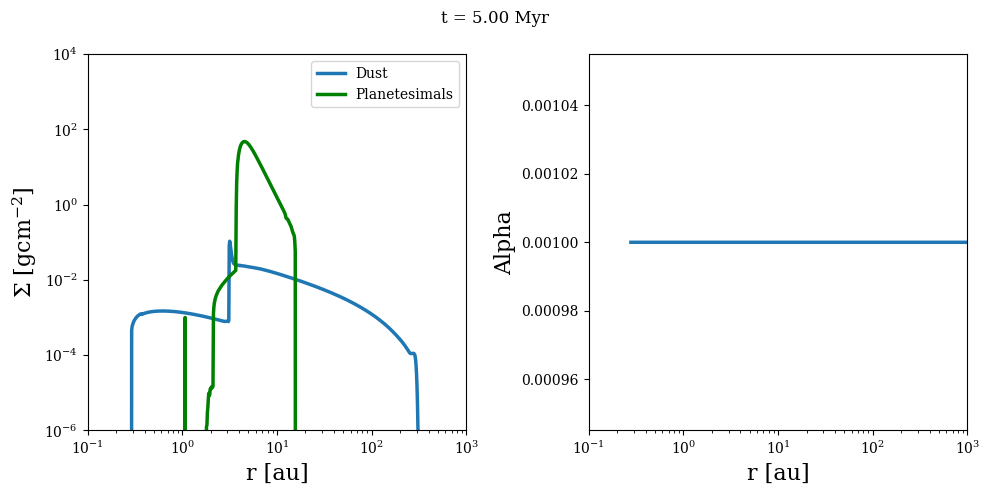

In [5]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 5))

it = -1
fig.suptitle(f't = {time[it]/year/1e6:.2f} Myr')

ax[1].semilogx(rgrid/au, alpha[it,:])
ax[1].set_ylabel('Alpha')
[axis.set_xlabel('r [au]') for axis in ax]

ax[0].loglog(rgrid/au, sigmad[it, :], label='Dust')
ax[0].loglog(rgrid/au, sigmaplts[it, :], 'g', label='Planetesimals')
ax[0].set_ylim(1e-6, 1e4)
ax[0].set_xlim(1e-1, 1e3)
ax[0].set_ylabel(r'$\Sigma$ [gcm$^{-2}$]')
ax[0].legend()
fig.set_tight_layout(True)

Text(0, 0.5, 'Temperature [K]')

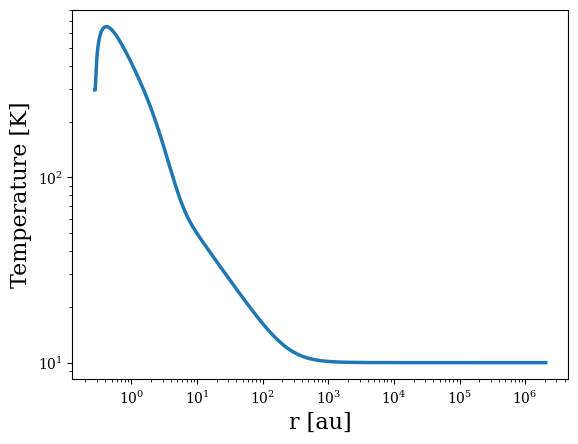

In [6]:
# Reproduce Lichtenberg+21 Figure 1?
temperature = read_data('temperature')

fig, ax = plt.subplots()
ax.loglog(rgrid/au, temperature[it, :])
ax.set_xlabel('r [au]')
ax.set_ylabel('Temperature [K]')

In [7]:
# 200 because no t=0 included
indices = np.zeros_like(time)
snowline_pos = np.zeros_like(time)

for i, temp_row in enumerate(temperature[1:]):
    idx = np.min( np.where(temp_row <= 150) )
    indices[i] = idx
    snowline_pos[i] = rgrid[idx]

Text(0.5, 0, 'Orbital distance, r [au]')

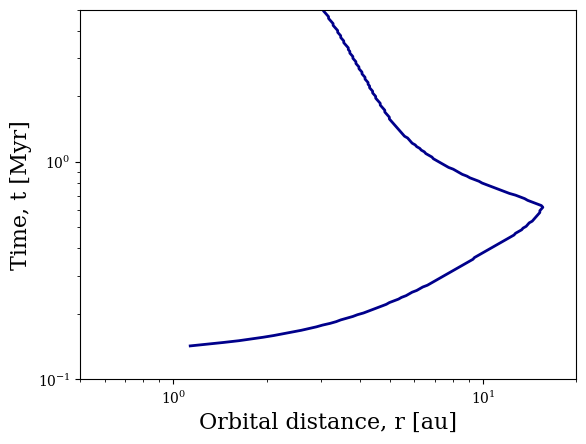

In [8]:
fig, ax = plt.subplots()

n = 6
ax.loglog(snowline_pos[n:-1]/au, time[n:-1]/year/1e6, color='darkblue', lw=2)
ax.set_xlim(0.5, 20)
ax.set_ylim(0.1, 5)
ax.set_ylabel('Time, t [Myr]')
ax.set_xlabel('Orbital distance, r [au]')

# Planetesimal formation rate
$$\dfrac{\rm{d}\Sigma_{\rm{plts}}}{\rm{d}t}$$

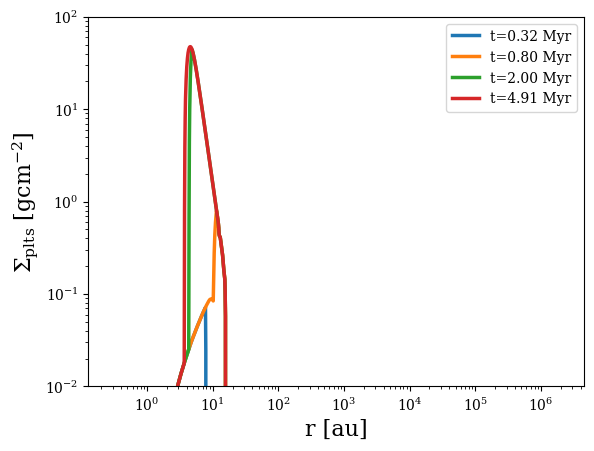

In [9]:
fig, ax = plt.subplots()

for N in [50, 100, 150, 199]:
    ax.loglog(rgrid/au, sigmaplts[N], label=f't={time[N]/year/1e6:.2f} Myr')
ax.set_ylim(1e-2, 1e2)
ax.set_ylabel(r'$\Sigma_{\rm{plts}}$ [gcm$^{-2}$]')
ax.set_xlabel('r [au]')
ax.legend()

In [10]:
# Planetesimal formation rate
dSigmaplts = np.diff(sigmaplts, axis=0)
dt = np.diff(time)
plts_rate = dSigmaplts/dt[:, None]


if False:
    plt.contourf(rgrid/au, time[1:]/year/1e6, np.log(plts_rate),    # IT'S LOG BASE e?! WHO DOES THAT
                levels=np.arange(-32, -25, 1))
    plt.xscale('log')
    plt.xlim(0.5, 20)
    plt.ylim(0.1, 5)
    plt.yscale('log')
    plt.colorbar()

/var/folders/rq/3x6pyqhd1qdffd3v4tvhyd4c07n5lh/T/ipykernel_2324/4176181701.py:11: RuntimeWarning: divide by zero encountered in log
  plt.contourf(rgrid/au, time[:reservoir_limit]/year/1e6, np.log(R1_rate),    # IT'S LOG BASE e?! WHO DOES THAT
/var/folders/rq/3x6pyqhd1qdffd3v4tvhyd4c07n5lh/T/ipykernel_2324/4176181701.py:15: RuntimeWarning: divide by zero encountered in log
  plt.contourf(rgrid/au, time[reservoir_limit:-1]/year/1e6, np.log(R2_rate),    # IT'S LOG BASE e?! WHO DOES THAT


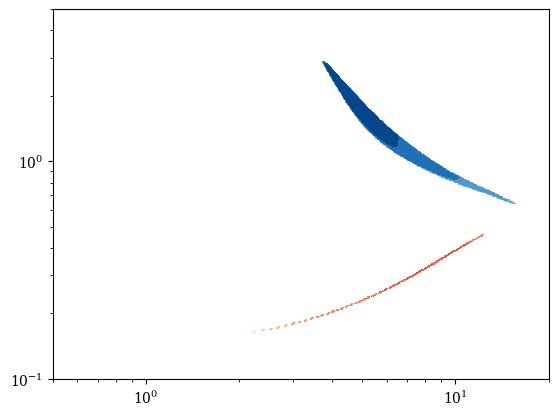

In [11]:
# Planetesimal reservoirs

reservoir_limit = np.min( np.where( (time/year/1e6) >= 0.6 ) )  # Time index separating reservoirs

R1_rate = plts_rate[:reservoir_limit, :]
R2_rate = plts_rate[reservoir_limit:, :]
R1_sigmaplts = sigmaplts[:reservoir_limit, :]
R2_sigmaplts = sigmaplts[reservoir_limit:, :]


plt.contourf(rgrid/au, time[:reservoir_limit]/year/1e6, np.log(R1_rate),    # IT'S LOG BASE e?! WHO DOES THAT
            levels=np.arange(-32, -25, 1),
            cmap='Reds')

plt.contourf(rgrid/au, time[reservoir_limit:-1]/year/1e6, np.log(R2_rate),    # IT'S LOG BASE e?! WHO DOES THAT
            levels=np.arange(-32, -25, 1),
            cmap='Blues')
plt.xscale('log')
plt.xlim(0.5, 20)
plt.ylim(0.1, 5)
plt.yscale('log')

/var/folders/rq/3x6pyqhd1qdffd3v4tvhyd4c07n5lh/T/ipykernel_2324/100828703.py:9: RuntimeWarning: divide by zero encountered in log
  cmap_R1 = ax.contourf(rgrid/au, time[:reservoir_limit]/year/1e6, np.log(R1_rate),    # IT'S LOG BASE e?! WHO DOES THAT
/var/folders/rq/3x6pyqhd1qdffd3v4tvhyd4c07n5lh/T/ipykernel_2324/100828703.py:13: RuntimeWarning: divide by zero encountered in log
  cmap_R2 = ax.contourf(rgrid/au, time[reservoir_limit:-1]/year/1e6, np.log(R2_rate),    # IT'S LOG BASE e?! WHO DOES THAT


Text(0, 0.5, 'Time, t [Myr]')

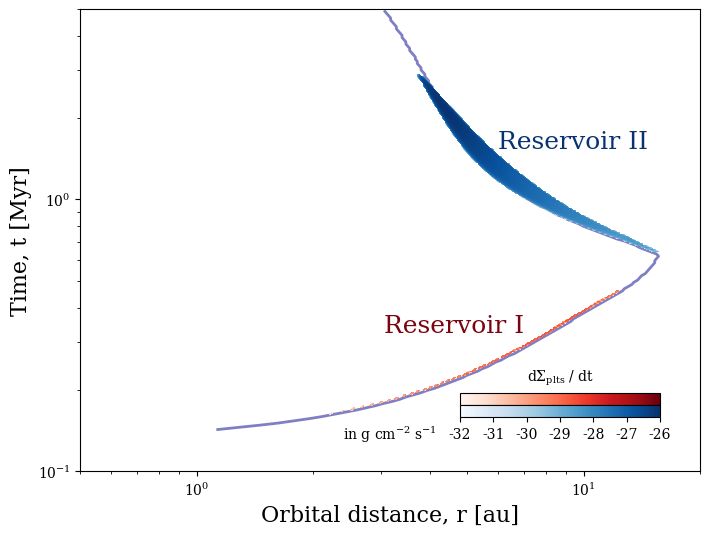

In [12]:

# levels = np.linspace(-33, -26, 128)

fig, ax = plt.subplots(figsize=(8,6))

levels = np.linspace(-32, -26, 128)
cbar_ticks = np.arange(-32, -25, 1)
ax.loglog(snowline_pos[n:-1]/au, time[n:-1]/year/1e6, color='darkblue', lw=2, zorder=-1, alpha=0.5) # Snowline

cmap_R1 = ax.contourf(rgrid/au, time[:reservoir_limit]/year/1e6, np.log(R1_rate),    # IT'S LOG BASE e?! WHO DOES THAT
                      levels=levels,
                      cmap='Reds')

cmap_R2 = ax.contourf(rgrid/au, time[reservoir_limit:-1]/year/1e6, np.log(R2_rate),    # IT'S LOG BASE e?! WHO DOES THAT
                      levels=levels,
                      cmap='Blues')

# Reservoir labels
ax.text(7, 0.3, 'Reservoir I', transform=ax.get_xaxis_transform(), fontsize=18, color='#79040f', ha='right')
ax.text(6, 0.7, 'Reservoir II', transform=ax.get_xaxis_transform(), fontsize=18, color='#083370')

# Colourbar
cax_x = 0.6
cax_y = 0.2
cax_dy = 0.02
cax_dx = 0.25
cax1 = fig.add_axes((cax_x, cax_y+cax_dy, cax_dx, cax_dy))
cax2 = fig.add_axes((cax_x, cax_y,        cax_dx, cax_dy))
cbar1 = fig.colorbar(cmap_R1, cax=cax1, orientation='horizontal')
cbar2 = fig.colorbar(cmap_R2, cax=cax2, orientation='horizontal')
cax1.xaxis.set_ticks([])
cax2.xaxis.set_ticks(cbar_ticks, np.astype(cbar_ticks, str))
text_x = float(cax_x + cax_dx/2)
text_y = float(cax_y + (2*cax_dy))

# Colourbar labels
ax.text(0.5, 2, r'$\rm{d}\Sigma_{\rm{plts}}~/~\rm{d}t$', transform=cax1.transAxes, ha='center')
ax.text(-0.35, -1.8, r'in g cm$^{-2}$ s$^{-1}$', transform=cax2.transAxes, ha='center')

# cbar = fig.colorbar(cmap_R1)
# cbar2 = fig.colorbar(cmap_R2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1, 5)
ax.set_xlim(0.5, 20)
ax.set_xlabel('Orbital distance, r [au]')
ax.set_ylabel('Time, t [Myr]')


# Pebble flux

<>:19: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\o'
/var/folders/rq/3x6pyqhd1qdffd3v4tvhyd4c07n5lh/T/ipykernel_2324/2517012750.py:19: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Pebble flux [M$_{\oplus}$ Myr$^{-1}$]')


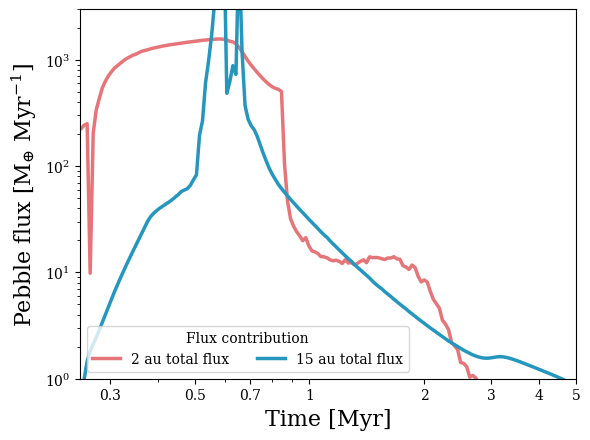

In [13]:
# Pebble flux
mflux = read_data('mflux')
mdot = read_data('mdot')
# mflux = pd.read_csv(directory+'mflux.dat').values.reshape(201, 1400)
# mdot = pd.read_csv(directory+'mdot.dat').values.reshape(201, 1400)

ME = c.M_earth.cgs.value



fig, ax = plt.subplots()
ir = (rgrid/au).searchsorted([1, 2, 15])
# ax.loglog(time/year/1e6, abs(mflux[:, ir[0]]) / ME * year * 1e6, label='1 au', color='springgreen')
ax.loglog(time/year/1e6, abs(mflux[:, ir[1]]) / ME * year * 1e6, color='#e67579')
ax.loglog(time/year/1e6, abs(mflux[:, ir[2]]) / ME * year * 1e6, color='#2596be')
ax.set_xlim(0.25, 5)
ax.set_ylim(1e0, 3e3)
ax.set_xlabel('Time [Myr]')
ax.set_ylabel('Pebble flux [M$_{\oplus}$ Myr$^{-1}$]')


from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color='#e67579', label='2 au total flux'),
           Line2D([0], [0], color='#2596be', label='15 au total flux'),]
ax.legend(handles=handles, title='Flux contribution', ncols=2, loc='lower left')

ticks = [0.3, 0.5, 0.7, 1, 2, 3, 4, 5]
tick_labels = [str(tick) for tick in ticks]
ax.set_xticks(ticks, tick_labels)

(0.25, 5)

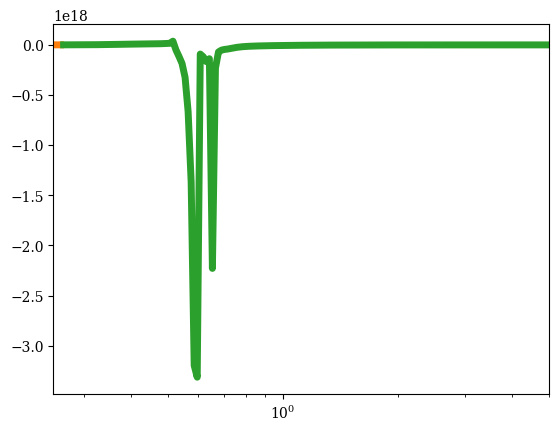

In [14]:

out_flux = np.where(mflux[:, ir[1]] > 1, mflux[:, ir[2]], np.nan)
in_flux = np.where(mflux[:, ir[1]] < 1, mflux[:, ir[2]], np.nan)
plt.plot(time/year/1e6, mflux[:, ir[2]], label='total flux')
plt.plot(time/year/1e6, out_flux, lw=5, label='outward flux')
plt.plot(time/year/1e6, in_flux, lw=5, label='inward flux')

# plt.plot(time/year/1e6, abs(mflux[:, ir[2]]), zorder=-1)
# plt.plot(time/year/1e6, abs(out_flux), linestyle='dotted', lw=5)


plt.xscale('log')
plt.xlim(0.25, 5)

# Supplementary Materials
## Figure S1

(201, 1400) failed...
(200, 1400) failed...


<>:71: SyntaxWarning: invalid escape sequence '\o'
<>:71: SyntaxWarning: invalid escape sequence '\o'
/var/folders/rq/3x6pyqhd1qdffd3v4tvhyd4c07n5lh/T/ipykernel_2324/2237643225.py:71: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Mass, M (M$_{\odot}$)')


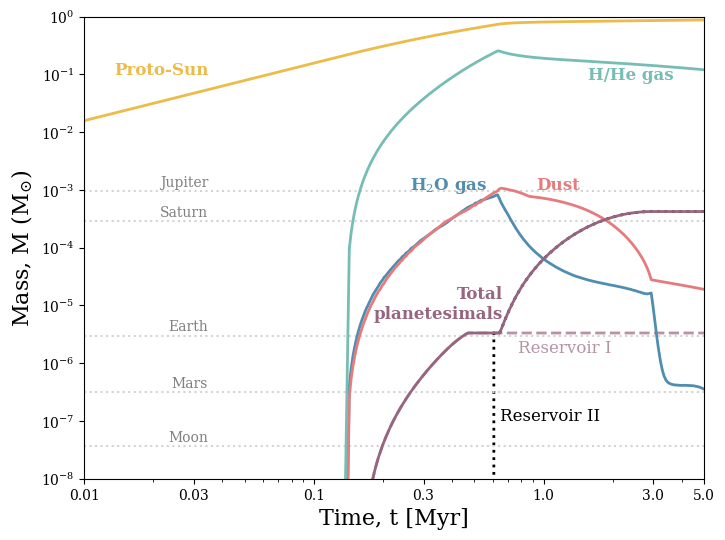

In [15]:
# Mass evolution of reservoirs
solar_clr = '#ecbb49'
H2O_clr = '#518db0'
dust_clr = '#e67b7e'
plts_clr = '#97657f'
gas_clr = '#76bdb4'

mstar = read_data('mstar')
sigmavap = read_data('sigmavap')
sigma_gas = read_data('sigma')

# dr element for integral
dr = np.zeros_like(rgrid)
dr_from_grid = np.diff(rgrid)
dr_ratio = dr_from_grid[1:]/dr_from_grid[:-1]
dr[:-1] = dr_from_grid
dr[-1] = dr_from_grid[-1] * dr_ratio[0]

# Masses
H2O_gas      = np.sum(2 * np.pi * rgrid * sigmavap * dr, axis=1)
dust_mass    = np.sum(2 * np.pi * rgrid * sigmad * dr, axis=1)
plts_mass    = np.sum(2 * np.pi * rgrid * sigmaplts * dr, axis=1)
gas_mass     = np.sum(2 * np.pi * rgrid * sigma_gas * dr, axis=1)
R1_mass      = np.sum(2 * np.pi * rgrid * R1_sigmaplts * dr, axis=1)
R2_mass      = np.sum(2 * np.pi * rgrid * R2_sigmaplts * dr, axis=1)

# Extend planetesimal mass for flat line
R1_mass_extend = np.zeros_like(time)
R1_mass_extend[:reservoir_limit] = R1_mass
R1_mass_extend[reservoir_limit:] = R1_mass[-1]

R2_mass_extend = np.zeros_like(time)
R2_mass_extend[reservoir_limit:] = R2_mass


M_sun = c.M_sun.cgs.value

fig, ax = plt.subplots(figsize=(8,6))
# Lines
ax.loglog(time/year/1e6, mstar/M_sun, color=solar_clr, lw=2)
ax.loglog(time/year/1e6, H2O_gas/M_sun, color=H2O_clr, lw=2)
ax.loglog(time/year/1e6, dust_mass/M_sun, color=dust_clr, lw=2)
ax.loglog(time/year/1e6, plts_mass/M_sun, color=plts_clr, lw=2)
ax.loglog(time/year/1e6, gas_mass/M_sun, color=gas_clr, lw=2)
ax.loglog(time/year/1e6, R1_mass_extend/M_sun, color=plts_clr, lw=2, linestyle='dashed', alpha=0.7, zorder=-1)
ax.loglog(time/year/1e6, R2_mass_extend/M_sun, color='k', lw=2, linestyle='dotted', zorder=-1)

# Labels
ax.text(0.2, 1e-1, 'Proto-Sun',             color=solar_clr, fontsize=12, ha='right', transform=ax.get_yaxis_transform(), fontweight='bold')
ax.text(0.65, 1e-3, 'H$_2$O gas',           color=H2O_clr, fontsize=12, ha='right', transform=ax.get_yaxis_transform(), fontweight='bold')
ax.text(0.8, 1e-3, 'Dust',                  color=dust_clr, fontsize=12, ha='right', transform=ax.get_yaxis_transform(), fontweight='bold')
ax.text(0.675, 6e-6, 'Total\nplanetesimals', color=plts_clr, fontsize=12, ha='right', transform=ax.get_yaxis_transform(), fontweight='bold')
ax.text(0.95, 8e-2, 'H/He gas',             color=gas_clr, fontsize=12, ha='right', transform=ax.get_yaxis_transform(), fontweight='bold')
ax.text(0.67, 1e-7, 'Reservoir II', color='k', fontsize=12, ha='left', transform=ax.get_yaxis_transform())
ax.text(0.7, 1.5e-6, 'Reservoir I', color=plts_clr, fontsize=12, ha='left', transform=ax.get_yaxis_transform(), alpha=0.7)

# Planets
                # Jupiter           Saturn    Earth                Mars     Moon
planet_masses = [c.M_jup.cgs.value, 5.683e29, c.M_earth.cgs.value, 6.39e26, 7.34e25]
planet_names = ['Jupiter', 'Saturn', 'Earth', 'Mars', 'Moon']

for mass, label in zip(planet_masses, planet_names):
    ax.axhline(mass/M_sun, lw=1.5, color='lightgray', zorder=-1, linestyle='dotted')
    ax.text(0.2, mass/M_sun*1.2, label, transform=ax.get_yaxis_transform(), fontsize=10, color='gray', ha='right')

# Adjustments
ax.set_xlim(0.01, 5)
ax.set_ylim(1e-8, 1e0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Mass, M (M$_{\odot}$)')
ax.set_xlabel('Time, t [Myr]')

# Set ticks to match Lichtenberg+21
ticks = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 5.0]
tick_labels = [str(tick) for tick in ticks]
ax.set_xticks(ticks, tick_labels)
ax.yaxis.minorticks_off()

In [16]:
infall = read_data('infall2')

(201, 1400) failed...
(200, 1400) failed...


Text(0, 0.5, 'Infall rate [g cm$^{-2}$ s$^{-1}$]')

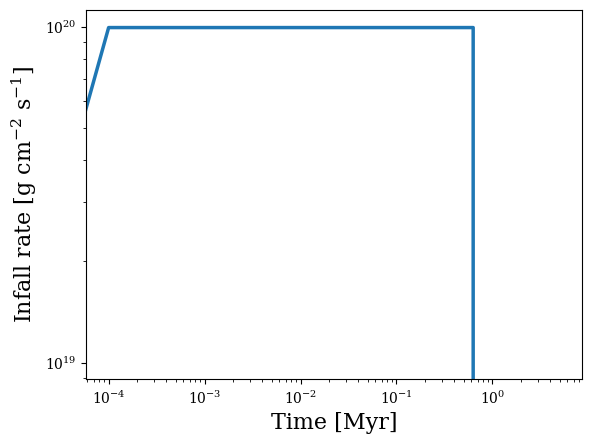

In [17]:
plt.figure()
plt.loglog(time/year/1e6, infall)
plt.xlabel('Time [Myr]')
plt.ylabel('Infall rate [g cm$^{-2}$ s$^{-1}$]')